In [1]:
import numpy as np
import os
import pathlib
import sys
import time
from joblib import load
import pandas as pd

# import all the libraries needed to train a neural network using labeled data, preferably using tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


if pathlib.Path(os.getcwd()).parents[2] not in sys.path:
    sys.path.append(str(pathlib.Path(os.getcwd()).parents[2]))

from Sensors.BatEcho.Spatializer import Render
from Sensors.BatEcho import Setting as sensorconfig
from Gym.BeaconDocking_v0 import Helper
from Arena import Builder

from Control.SensorimotorLoops.BatEcho import AvoidApproach, Avoid
from Simulation.Motion import State
from Control.SensorimotorLoops import Setting as controlconfig

In [2]:
# load pandas dataframe from labeled_echo_data/run_ApproachProb_0.3_11.13.22.pkl
# this is the data that was generated by running run_labeler_collection.py APPROACH_LIKELIHOOD = 0.3
# load the data
df = pd.read_pickle('labeled_echo_data/run_ApproachProb_0.5_11.14.22.pkl')
# print all the columns headers
print(df.columns)
# print the first 2 rows of the data
print(df.head(2))
#print the size of the data
print(df.shape)


Index(['compresses', 'poses', 'actions', 'zones'], dtype='object')
                                          compresses  \
0  [[0.0, 2.418235718706148, 3.09862125035642, 1....   
1  [[0.0, 2.420419978865343, 3.0985833960855307, ...   

                                               poses  \
0  [[-2.1264014331680494, -2.2341875172081496, 2....   
1  [[-2.395534233402584, 2.350599183138514, 2.532...   

                                             actions  \
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                               zones  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
(12000, 4)


In [3]:
for i in range(df.shape[0]):
    df['compresses'][i] = df['compresses'][i][:-1]
    df['poses'][i] = df['poses'][i][:-1]
    df['actions'][i] = np.asarray(df['actions'][i])
    df['zones'][i] = np.asarray(df['zones'][i])
echo_data = np.vstack(df['compresses'])
poses_data = np.vstack(df['poses'])
actions_data = np.concatenate(df['actions'])
zones_data = np.concatenate(df['zones'])
print(f'echo shape: {echo_data.shape}, poses shape: {poses_data.shape},actions shape: {actions_data.shape}, zones shape: {zones_data.shape}')

echo shape: (2864546, 112), poses shape: (2864546, 3),actions shape: (2864546,), zones shape: (2864546,)


In [4]:
zone_0_proportion = np.sum(zones_data == 0) / zones_data.shape[0]
zone_1_proportion = np.sum(zones_data == 1) / zones_data.shape[0]
zone_2_proportion = np.sum(zones_data == 2) / zones_data.shape[0]
zone_3_proportion = np.sum(zones_data == 3) / zones_data.shape[0]
# print out the proportion of each zone in the data round to last 2 decimals
print(f'zone 0 proportion: {zone_0_proportion:.2f}, zone 1 proportion: {zone_1_proportion:.2f}, zone 2 proportion: {zone_2_proportion:.2f}, zone 3 proportion: {zone_3_proportion:.2f}')

zone 0 proportion: 0.16, zone 1 proportion: 0.31, zone 2 proportion: 0.23, zone 3 proportion: 0.30


In [5]:
action_0_proportion = np.sum(actions_data == 0) / actions_data.shape[0]
action_1_proportion = np.sum(actions_data == 1) / actions_data.shape[0]
# print out the proportion of each action
print(f'action 0 proportion: {action_0_proportion:.2f}, action 1 proportion: {action_1_proportion:.2f}')

action 0 proportion: 0.73, action 1 proportion: 0.27


In [6]:
#partition the echo_date in to each zone
zone_0_echo_data = echo_data[zones_data == 0]
zone_1_echo_data = echo_data[zones_data == 1]
zone_2_echo_data = echo_data[zones_data == 2]
zone_3_echo_data = echo_data[zones_data == 3]
# partition the actions_data in to each zone
zone_0_actions_data = actions_data[zones_data == 0]
zone_1_actions_data = actions_data[zones_data == 1]
zone_2_actions_data = actions_data[zones_data == 2]
zone_3_actions_data = actions_data[zones_data == 3]
#
shuffle_idx=np.random.permutation(len(zone_0_echo_data))
zone_0_echo_data = zone_0_echo_data[shuffle_idx]
zone_0_action_data = zone_0_actions_data[shuffle_idx]
shuffle_idx=np.random.permutation(len(zone_1_echo_data))
zone_1_echo_data = zone_1_echo_data[shuffle_idx]
zone_1_action_data = zone_1_actions_data[shuffle_idx]
shuffle_idx=np.random.permutation(len(zone_2_echo_data))
zone_2_echo_data = zone_2_echo_data[shuffle_idx]
zone_2_action_data = zone_2_actions_data[shuffle_idx]
shuffle_idx=np.random.permutation(len(zone_3_echo_data))
zone_3_echo_data = zone_3_echo_data[shuffle_idx]
zone_3_action_data = zone_3_actions_data[shuffle_idx]
#print size of each zone
print(f'zone 0:{len(zone_0_echo_data)}, zone 1:{len(zone_1_echo_data)}, zone 2:{len(zone_2_echo_data)}, zone 3:{len(zone_3_echo_data)}')



zone 0:460536, zone 1:893659, zone 2:659705, zone 3:850646


In [ ]:
zone_1_echo_data = zone_1_echo_data[:int(0.5*len(zone_1_echo_data))]
zone_1_action_data = zone_1_action_data[:int(0.5*len(zone_1_action_data))]
zone_2_echo_data = zone_2_echo_data[:int(0.001*len(zone_2_echo_data))]
zone_2_action_data = zone_2_action_data[:int(0.001*len(zone_2_action_data))]
zone_3_echo_data = zone_3_echo_data[:int(0.5*len(zone_3_echo_data))]
zone_3_action_data = zone_3_action_data[:int(0.5*len(zone_3_action_data))]

zone_0_proportion = len(zone_0_echo_data) / (len(zone_0_echo_data) + len(zone_1_echo_data) + len(zone_2_echo_data) + len(zone_3_echo_data))
zone_1_proportion = len(zone_1_echo_data) / (len(zone_0_echo_data) + len(zone_1_echo_data) + len(zone_2_echo_data) + len(zone_3_echo_data))
zone_2_proportion = len(zone_2_echo_data) / (len(zone_0_echo_data) + len(zone_1_echo_data) + len(zone_2_echo_data) + len(zone_3_echo_data))
zone_3_proportion = len(zone_3_echo_data) / (len(zone_0_echo_data) + len(zone_1_echo_data) + len(zone_2_echo_data) + len(zone_3_echo_data))
# print out the proportion of each zone in the data round to last 2 decimals
print(f'zone 0 proportion: {zone_0_proportion:.2f}, zone 1 proportion: {zone_1_proportion:.2f}, zone 2 proportion: {zone_2_proportion:.2f}, zone 3 proportion: {zone_3_proportion:.2f}')

action_0_proportion = np.sum(zone_0_action_data == 0)
action_0_proportion+= np.sum(zone_1_action_data == 0)
action_0_proportion+= np.sum(zone_2_action_data == 0)
action_0_proportion+= np.sum(zone_3_action_data == 0)
action_0_proportion = action_0_proportion / (zone_0_action_data.shape[0] + zone_1_action_data.shape[0] + zone_2_action_data.shape[0] + zone_3_action_data.shape[0])
action_1_proportion = np.sum(zone_0_action_data == 1)
action_1_proportion+= np.sum(zone_1_action_data == 1)
action_1_proportion+= np.sum(zone_2_action_data == 1)
action_1_proportion+= np.sum(zone_3_action_data == 1)
action_1_proportion = action_1_proportion / (zone_0_action_data.shape[0] + zone_1_action_data.shape[0] + zone_2_action_data.shape[0] + zone_3_action_data.shape[0])
# print out the proportion of each action
print(f'action 0 proportion: {action_0_proportion:.2f}, action 1 proportion: {action_1_proportion:.2f}')

In [7]:
# import train_test_split
from sklearn.model_selection import train_test_split

# stack all zone_*_echo_data into (N,112) array as X
# stack all zone_*_action_data into (N,) array as y
# slice X and y into train and test sets (0.8,0.2)
X = np.vstack((zone_0_echo_data, zone_1_echo_data, zone_2_echo_data, zone_3_echo_data))
y = np.hstack((zone_0_action_data, zone_1_action_data, zone_2_action_data, zone_3_action_data))
print(y.shape)
# convert y (N,) to one-hot (N,2)
y = np.eye(2)[y.astype(int)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


(2864546,)


In [8]:
# print shape of X_train, X_test, y_train, y_test in different lines for train and test
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')


X_train shape: (2291636, 112), X_test shape: (572910, 112), y_train shape: (2291636, 2), y_test shape: (572910, 2)


In [9]:
# create a neural network model that take in 1D input of size (112,) and output 2D output of size (2,) probability of action 0 and action 1
# use relu activation for hidden layer and softmax activation for output layer
# use adam optimizer and categorical cross entropy loss
# print out model summary
# hidden layers is (128, 128, 128, 64)
# use l2 regularization with lambda = 1e-
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

lam = 1e-5
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(112,), kernel_regularizer=regularizers.l2(lam)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lam)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(lam)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(lam)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               14464     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 55,874
Trainable params: 55,874
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1000
448/448 [==============================] - 2s 3ms/step - loss: 0.5004 - accuracy: 0.7662 - val_loss: 0.4569 - val_accuracy: 0.7924
Epoch 2/1000
448/448 [==============================] - 1s 2ms/step - loss: 0.4563 - accuracy: 0.7924 - val_loss: 0.4546 - val_accuracy: 0.7935
Epoch 3/1000
448/448 [==============================] - 1s 2ms/step - loss: 0.4545 - accuracy: 0.7928 - val_loss: 0.4520 - val_accuracy: 0.7949
Epoch 4/1000
448/448 [==============================] - 1s 2ms/step - loss: 0.4526 - accuracy: 0.7935 - val_loss: 0.4515 - val_accuracy: 0.7946
Epoch 5/1000
448/448 [==============================] - 1s 2ms/step - loss: 0.4508 - accuracy: 0.7944 - val_loss: 0.4514 - val_accuracy: 0.7947
Epoch 6/1000
448/448 [==============================] - 1s 2ms/step - loss: 0.4503 - accuracy: 0.7946 - val_loss: 0.4512 - val_accuracy: 0.7950
Epoch 7/1000
448/448 [==============================] - 1s 2ms/step - loss: 0.4500 - accuracy: 0.7947 - val_loss: 0.4490 - val_accuracy:

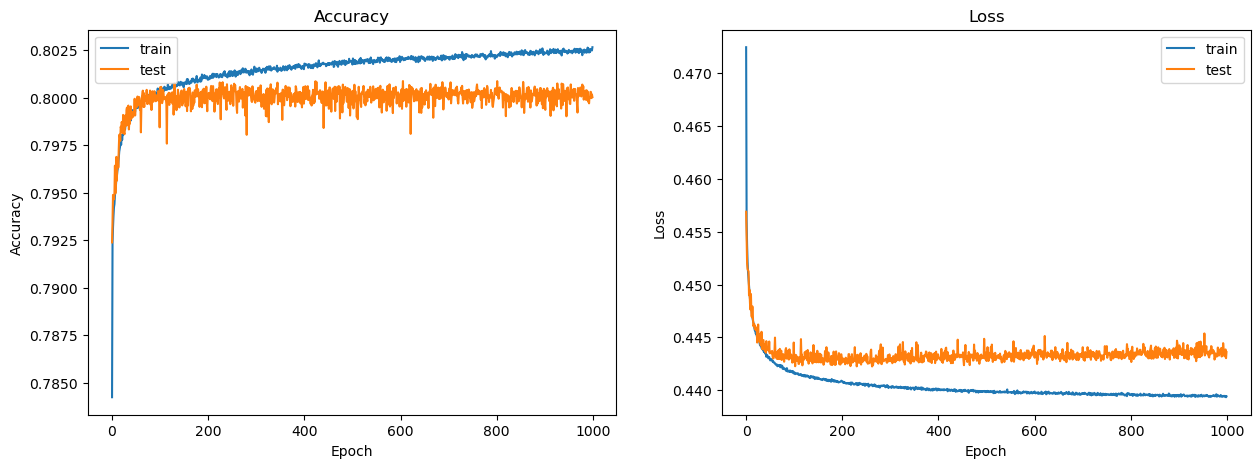

In [10]:
from matplotlib import pyplot as plt
# train the model with X_train and y_train, 
# evaluate the model with X_test and y_test 
# for 1_000 epochs or until accuracy is 0.999 or convergence
# batch size is 64
# verbose is 1
# validation_split is 0.2
# shuffle is True
# callbacks is EarlyStopping with patience of 1000
# save the model to 'model.h5'
# plot the training and validation accuracy and loss in real time every 1 epochs
# print out the final training and validation accuracy and loss

history = model.fit(X_train, y_train, epochs=1000, batch_size=4096, verbose=1, validation_split=0.2, shuffle=True, callbacks=[keras.callbacks.EarlyStopping(patience=1000)], validation_data=(X_test, y_test))
# if there is no folder called trained_model, create one
if not os.path.exists('trained_model'):
    os.makedirs('trained_model')
# save the model
# get date in format of MM.DD.YY
DATE = time.strftime("%m.%d.%Y")
model.save(f'trained_model/model_AL0.5_{DATE}.h5')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['accuracy'], label='train')
ax[0].plot(history.history['val_accuracy'], label='test')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='test')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()


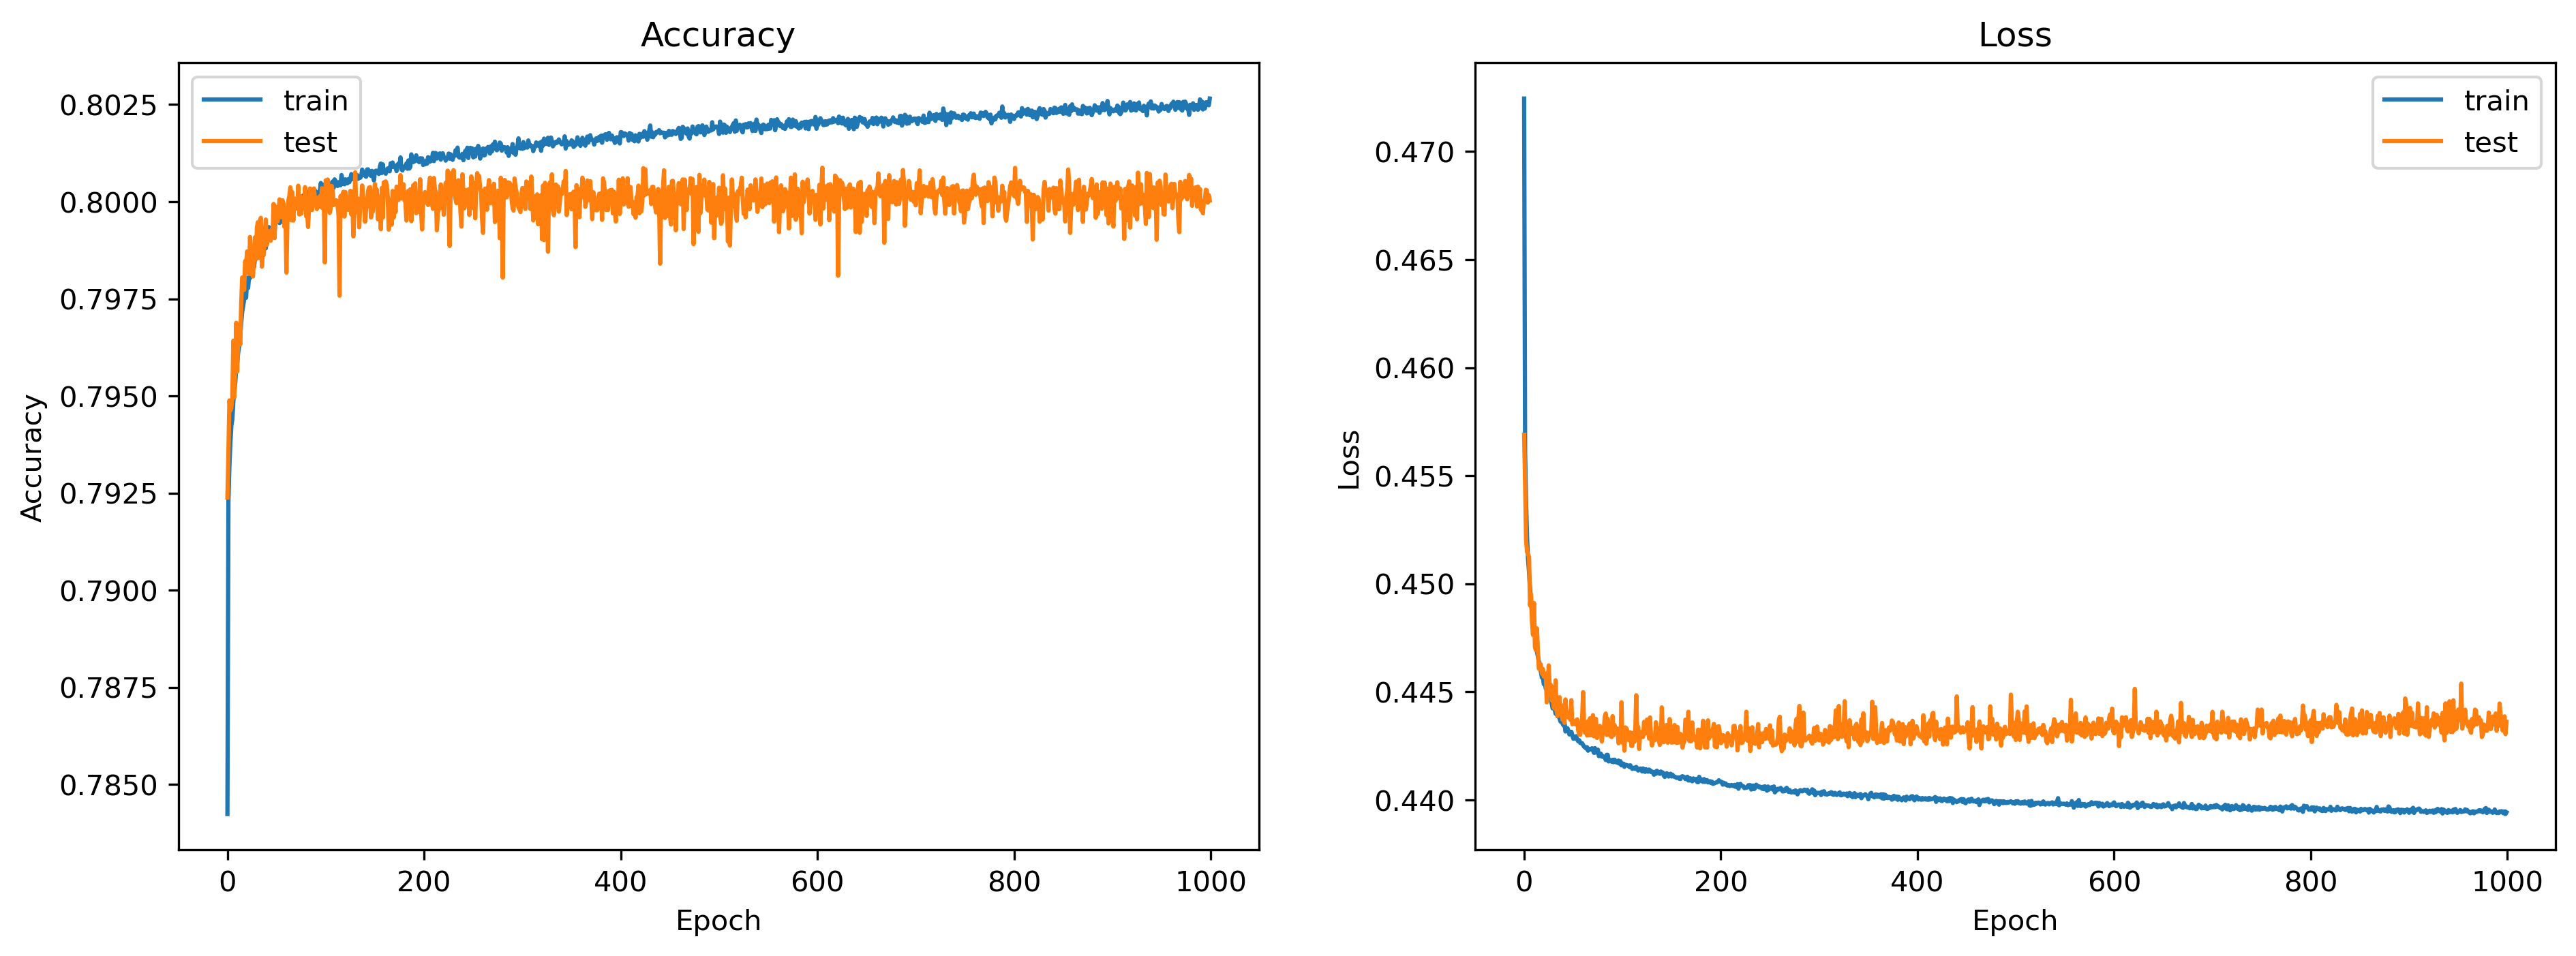

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)

ax[0].plot(history.history['accuracy'], label='train')
ax[0].plot(history.history['val_accuracy'], label='test')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='test')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

# save the figure in trained_model folder as model_AL0.3_MM.DD.YY.png   
fig.savefig(f'trained_model/model_AL0.5_{DATE}.png')

In [12]:
# evaluate the model with X_test and y_test
# print out the final test accuracy and loss
score = model.evaluate(X_test, y_test, verbose=10)
print(f'Test loss: {score[0]:.2f}, Test accuracy: {score[1]:.2f}')



Test loss: 0.44, Test accuracy: 0.80


In [ ]:
!git add train_controller_using_labeled_data.ipynb
!git commit -m "add train_controller_using_labeled_data.ipynb"
!git push
!git add trained_model
!git commit -m "add trained_model"
!git push
